# Tool Wear Detection

https://www.kaggle.com/datasets/shasun/tool-wear-detection-in-cnc-mill

https://www.kaggle.com/code/koheimuramatsu/cnc-milling-machine-tool-wear-detection

In [1]:
import os

# The Vertex AI Workbench Notebook product has specific requirements
IS_WORKBENCH_NOTEBOOK = os.getenv("DL_ANACONDA_HOME") and not os.getenv("VIRTUAL_ENV")

# Vertex AI Notebook requires dependencies to be installed with '--user'
USER_FLAG = ""
if IS_WORKBENCH_NOTEBOOK:
    USER_FLAG = "--user"
    
! pip3 install fsspec gcsfs $USER_FLAG -q
! pip3 install tensorflow-data-validation $USER_FLAG -q
! pip3 install --upgrade google-cloud-aiplatform $USER_FLAG -q

## GCP Setup

### Project ID

In [2]:
PROJECT_ID = "[your-project-id]"  # @param {type:"string"}

In [3]:
if PROJECT_ID == "" or PROJECT_ID is None or PROJECT_ID == "[your-project-id]":
    # Get your GCP project id from gcloud
    shell_output = ! gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID:", PROJECT_ID)

Project ID: mde-ml-dev-01


In [4]:
! gcloud config set project $PROJECT_ID

Updated property [core/project].


### Region

In [5]:
REGION = "[your-region]"  # @param {type: "string"}

if REGION == "[your-region]":
    REGION = "us-central1"

print('Region:', REGION)

Region: us-central1


### Cloud Storage Bucket

In [6]:
BUCKET_NAME = "[your-bucket-name]"  # @param {type:"string"}
BUCKET_URI = f"gs://{BUCKET_NAME}"

In [7]:
if BUCKET_URI == "" or BUCKET_URI is None or BUCKET_URI == "gs://[your-bucket-name]":
    BUCKET_URI = "gs://" + PROJECT_ID + "-ml"

print('BUCKET_URI:', BUCKET_URI)

BUCKET_URI: gs://mde-ml-dev-01-ml


Only if your bucket doesn't already exist: Run the following cell to create your Cloud Storage bucket.


In [8]:
! gsutil mb -l $REGION $BUCKET_URI

Creating gs://mde-ml-dev-01-ml/...
ServiceException: 409 A Cloud Storage bucket named 'mde-ml-dev-01-ml' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


In [9]:
! gsutil ls -al $BUCKET_URI

   7333245  2022-08-29T18:34:16Z  gs://mde-ml-dev-01-ml/ experiments_train_split_processed2.csv#1661798055991118  metageneration=1
   6978771  2022-08-26T14:25:43Z  gs://mde-ml-dev-01-ml/experiment_train_merged_dropped.csv#1661523943652656  metageneration=1
   7269671  2022-08-25T21:45:27Z  gs://mde-ml-dev-01-ml/experiments_train_merged.csv#1661463927499873  metageneration=1
   7522996  2022-08-26T15:50:51Z  gs://mde-ml-dev-01-ml/experiments_train_split.csv#1661529051627533  metageneration=1
   7529574  2022-08-26T18:51:03Z  gs://mde-ml-dev-01-ml/experiments_train_split2_processed.csv#1661539863419512  metageneration=1
   7522992  2022-08-26T18:27:38Z  gs://mde-ml-dev-01-ml/experiments_train_split_processed.csv#1661538458882294  metageneration=1
   1185395  2022-08-26T15:12:44Z  gs://mde-ml-dev-01-ml/test.csv#1661526764448576  metageneration=1
   9391140  2022-08-29T19:27:14Z  gs://mde-ml-dev-01-ml/tool_wear_split_proc2_feat.csv#1661801234580187  metageneration=1
   9391140  2022-08-30

### Service Account

In [10]:
shell_output = !gcloud auth list 2>/dev/null
SERVICE_ACCOUNT = shell_output[2].replace("*", "").strip()

print('SERVICE_ACCOUNT:', SERVICE_ACCOUNT)

SERVICE_ACCOUNT: 944080718770-compute@developer.gserviceaccount.com


### Grant Service Account Permission

In [11]:
! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.objectCreator $BUCKET_URI

! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.objectViewer $BUCKET_URI

No changes made to gs://mde-ml-dev-01-ml/
No changes made to gs://mde-ml-dev-01-ml/


## Import libraries

In [12]:
import os

import google.cloud.aiplatform as vertex_ai
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

matplotlib.style.use('ggplot')
plt.figure(figsize=(40,20))
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

# File path to downloaded dataset
DATA_PATH = '/home/jupyter/tool_wear'
# Label column name
LABEL_COL = 'tool_condition'
# Split column name
SPLIT_COL = 'ml_use'
# Vertex AI artifacts prefix
VERTEX_AI_PREFIX = 'tool_wear_v3_split3' # TODO: change me

vertex_ai.init(project=PROJECT_ID)

<Figure size 2880x1440 with 0 Axes>

## Get Dataset

Download the [tool wear dataset](https://www.kaggle.com/datasets/shasun/tool-wear-detection-in-cnc-mill) from Kaggle and upload to Vertex AI notebook as `archive.zip`. The code cell below will extract the dataset.

In [13]:
from zipfile import ZipFile

with ZipFile(f'{DATA_PATH}/archive.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall(DATA_PATH)

## Merge training files

In [14]:
df_train_csv = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))

df_train_csv.head()

No material  feedrate  clamp_pressure tool_condition machining_finalized  \
0   1      wax         6             4.0         unworn                 yes   
1   2      wax        20             4.0         unworn                 yes   
2   3      wax         6             3.0         unworn                 yes   
3   4      wax         6             2.5         unworn                  no   
4   5      wax        20             3.0         unworn                  no   

  passed_visual_inspection  
0                      yes  
1                      yes  
2                      yes  
3                      NaN  
4                      NaN

In [15]:
experiment_ids = list(df_train_csv['No'].unique())

li_df_experiments = []

for id in experiment_ids:
    filename = f'experiment_{id:0>2d}.csv' # Pad number with zeros (left padding, width 2)
    df = pd.read_csv(os.path.join(DATA_PATH, filename), index_col=None)
    df['No'] = id
    df = df.merge(df_train_csv, how='left', on='No')
    print(f'experiment id: {id} | shape: {df.shape}')
    
    li_df_experiments.append(df)
    
df_experiments = pd.concat(li_df_experiments, axis=0, ignore_index=True)

experiment id: 1 | shape: (1055, 55)
experiment id: 2 | shape: (1668, 55)
experiment id: 3 | shape: (1521, 55)
experiment id: 4 | shape: (532, 55)
experiment id: 5 | shape: (462, 55)
experiment id: 6 | shape: (1296, 55)
experiment id: 7 | shape: (565, 55)
experiment id: 8 | shape: (605, 55)
experiment id: 9 | shape: (740, 55)
experiment id: 10 | shape: (1301, 55)
experiment id: 11 | shape: (2314, 55)
experiment id: 12 | shape: (2276, 55)
experiment id: 13 | shape: (2233, 55)
experiment id: 14 | shape: (2332, 55)
experiment id: 15 | shape: (1381, 55)
experiment id: 16 | shape: (602, 55)
experiment id: 17 | shape: (2150, 55)
experiment id: 18 | shape: (2253, 55)


In [16]:
df_experiments.head()

X1_ActualPosition  X1_ActualVelocity  X1_ActualAcceleration  \
0              198.0                0.0                   0.00   
1              198.0              -10.8                -350.00   
2              196.0              -17.8                  -6.25   
3              194.0              -18.0                   0.00   
4              193.0              -17.9                 -18.80   

   X1_CommandPosition  X1_CommandVelocity  X1_CommandAcceleration  \
0               198.0                 0.0                0.000000   
1               198.0               -13.6             -358.000000   
2               196.0               -17.9               -0.000095   
3               194.0               -17.9               -0.000095   
4               192.0               -17.9                0.000095   

   X1_CurrentFeedback  X1_DCBusVoltage  X1_OutputCurrent  X1_OutputVoltage  \
0                0.18           0.0207             329.0              2.77   
1              -10.90           0.1860             328.0             23.30   
2               -8.59           0.1400             328.0             30.60   
3               -6.11           0.1300             327.0             30.30   
4               -5.70           0.1140             328.0             30.50   

   X1_OutputPower  Y1_ActualPosition  Y1_ActualVelocity  \
0       -0.000001              158.0             -0.025   
1        0.004480              158.0            -19.800   
2        0.005330              154.0            -32.500   
3        0.004890              151.0            -32.600   
4        0.004250              148.0            -32.000   

   Y1_ActualAcceleration  Y1_CommandPosition  Y1_CommandVelocity  \
0                  -6.25               158.0                 0.0   
1                -750.00               157.0               -24.6   
2                   0.00               154.0               -32.3   
3                 -62.50               151.0               -32.3   
4                 138.00               148.0               -32.3   

   Y1_CommandAcceleration  Y1_CurrentFeedback  Y1_DCBusVoltage  \
0                0.000000               0.539           0.0167   
1             -647.000000             -14.500           0.2810   
2               -0.000095              -7.790           0.1390   
3               -0.000095              -8.130           0.1560   
4                0.000095             -13.800           0.2020   

   Y1_OutputCurrent  Y1_OutputVoltage  Y1_OutputPower  Z1_ActualPosition  \
0             328.0              1.84    6.430000e-07              119.0   
1             325.0             37.80    1.260000e-02              119.0   
2             327.0             49.40    9.430000e-03              115.0   
3             325.0             47.60    1.050000e-02              112.0   
4             326.0             47.10    1.350000e-02              109.0   

   Z1_ActualVelocity  Z1_ActualAcceleration  Z1_CommandPosition  \
0                0.0                   0.00               119.0   
1              -20.3                -712.00               118.0   
2              -33.7                  37.50               115.0   
3              -33.7                  -6.25               112.0   
4              -33.6                  18.80               108.0   

   Z1_CommandVelocity  Z1_CommandAcceleration  Z1_CurrentFeedback  \
0                 0.0                0.000000                 0.0   
1               -25.6             -674.000000                 0.0   
2               -33.7               -0.000095                 0.0   
3               -33.7                0.000000                 0.0   
4               -33.7                0.000000                 0.0   

   Z1_DCBusVoltage  Z1_OutputCurrent  Z1_OutputVoltage  S1_ActualPosition  \
0              0.0               0.0               0.0             -361.0   
1              0.0               0.0               0.0             -361.0   
2              0.0               0.0               0.0 

## EDA

In [17]:
df_train_csv.describe(include='all')

No material   feedrate  clamp_pressure tool_condition  \
count   18.000000       18  18.000000       18.000000             18   
unique        NaN        1        NaN             NaN              2   
top           NaN      wax        NaN             NaN           worn   
freq          NaN       18        NaN             NaN             10   
mean     9.500000      NaN   9.722222        3.416667            NaN   
std      5.338539      NaN   7.282578        0.624264            NaN   
min      1.000000      NaN   3.000000        2.500000            NaN   
25%      5.250000      NaN   3.000000        3.000000            NaN   
50%      9.500000      NaN   6.000000        3.500000            NaN   
75%     13.750000      NaN  18.750000        4.000000            NaN   
max     18.000000      NaN  20.000000        4.000000            NaN   

       machining_finalized passed_visual_inspection  
count                   18                       14  
unique                   2                        2  
top                    yes                      yes  
freq                    14                       10  
mean                   NaN                      NaN  
std                    NaN                      NaN  
min                    NaN                      NaN  
25%                    NaN                      NaN  
50%                    NaN                      NaN  
75%                    NaN                      NaN  
max                    NaN                      NaN

In [18]:
df_experiments.describe()

X1_ActualPosition  X1_ActualVelocity  X1_ActualAcceleration  \
count       25286.000000       25286.000000           25286.000000   
mean          159.052045          -0.288657               0.094264   
std            19.330873           5.658260              93.877623   
min           141.000000         -20.400000           -1280.000000   
25%           145.000000          -2.050000             -31.300000   
50%           153.000000           0.000000               0.000000   
75%           162.000000           0.200000              25.000000   
max           198.000000          50.700000            1440.000000   

       X1_CommandPosition  X1_CommandVelocity  X1_CommandAcceleration  \
count        25286.000000        25286.000000            25286.000000   
mean           159.050700           -0.283076                0.253215   
std             19.331144            5.664309               72.594951   
min            141.000000          -20.000000            -1000.000000   
25%            145.000000           -2.050000                0.000000   
50%            153.000000            0.000000                0.000000   
75%            162.000000            0.000000                0.000000   
max            198.000000           50.000000             1000.000000   

       X1_CurrentFeedback  X1_DCBusVoltage  X1_OutputCurrent  \
count        25286.000000     2.528600e+04      25286.000000   
mean            -0.469714     6.603073e-02        326.945859   
std              4.220750     3.700384e-02          1.459937   
min            -23.400000     2.780000e-19        320.000000   
25%             -3.930000     4.150000e-02        326.000000   
50%             -0.666000     6.680000e-02        327.000000   
75%              3.140000     9.130000e-02        327.000000   
max             27.100000     3.800000e-01        331.000000   

       X1_OutputVoltage  X1_OutputPower  Y1_ActualPosition  Y1_ActualVelocity  \
count      25286.000000    25286.000000       25286.000000       25286.000000   
mean           7.986942        0.000610          99.230064          -0.422932   
std            7.710379        0.001565          29.244880           6.006439   
min            0.000000       -0.006060          72.400000         -32.800000   
25%            2.590000        0.000000          77.500000          -0.075000   
50%            7.140000        0.000174          90.000000           0.000000   
75%           10.200000        0.000585         105.000000           0.100000   
max           75.400000        0.038800         158.000000          50.400000   

       Y1_ActualAcceleration  Y1_CommandPosition  Y1_CommandVelocity  \
count           25286.000000        25286.000000        25286.000000   
mean                0.928832           99.226271           -0.412075   
std                85.074580           29.242802            6.004721   
min             -1260.000000           72.400000          -32.400000   
25%               -18.800000           77.500000            0.000000   
50%                 0.000000           90.000000            0.000000   
75%                18.800000          105.000000            0.000000   
max              1460.000000          158.000000           50.000000   

       Y1_CommandAcceleration  Y1_CurrentFeedback  Y1_DCBusVoltage  \
count            25286.000000        25286.000000     2.528600e+04   
mean                 1.484158           -0.061681     6.398315e-02   
std                 81.358073            4.469548     4.777806e-02   
min              -1000.000000          -27.800000     2.680000e-19   
25%                  0.000000           -3.090000     2.190000e-02   
50%                  0.000000            0.146000     5.780000e-02   
75%                  0.000000            2.900000     9.557500e-02   
max               1000.000000           30.700000     4.300000e-01   

       Y1_OutputCurrent  Y1_OutputVoltage  Y1_OutputPower  Z1_ActualPosition  \
count      25286.000000      25286.000000    25286.

In [19]:
import tensorflow_data_validation as tfdv

stats = tfdv.generate_statistics_from_dataframe(
    dataframe=df_experiments,
    stats_options=tfdv.StatsOptions(
        label_feature=LABEL_COL, sample_rate=1, num_top_values=50
    ),
)

2022-09-02 15:10:29.247726: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-02 15:10:29.247795: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [20]:
tfdv.visualize_statistics(stats)

### Observations

#### Bad

1. There are some numerical columns (e.g. `Z1_CurrentFeedback`, `Z1_DCBusVoltage`) where there are only zeros.
1. There are some numerical columns (e.g. `Z1_CommandVelocity`, `Z1_CommandAcceleration`) where there are greater than 50% of zeros.
1. Some of the actual and command values have more than 50% of discrepancy in their values. For example, `X1_CommandAcceleration` contains 73.12% of zeros while `X1_ActualAcceleration` has 13.66% of zeros. 
1. `S1_SystemInertia` has same min, mean, median, and max (i.e. 12). 
1. `passed_visual_inspection` has missing values.

#### Good

1. The number of data points across `worn` (i.e. 13308) and `unworn` (i.e. 11978) classes are relatively balanced. 


In [21]:
df_experiments.nunique()

X1_ActualPosition              58
X1_ActualVelocity             830
X1_ActualAcceleration         259
X1_CommandPosition             58
X1_CommandVelocity           1739
X1_CommandAcceleration       2296
X1_CurrentFeedback           2386
X1_DCBusVoltage              1042
X1_OutputCurrent               12
X1_OutputVoltage             1831
X1_OutputPower               4835
Y1_ActualPosition             335
Y1_ActualVelocity             859
Y1_ActualAcceleration         264
Y1_CommandPosition            335
Y1_CommandVelocity           1786
Y1_CommandAcceleration       2245
Y1_CurrentFeedback           3027
Y1_DCBusVoltage              1084
Y1_OutputCurrent               15
Y1_OutputVoltage             2044
Y1_OutputPower               5706
Z1_ActualPosition             474
Z1_ActualVelocity             244
Z1_ActualAcceleration         177
Z1_CommandPosition            484
Z1_CommandVelocity             74
Z1_CommandAcceleration         31
Z1_CurrentFeedback              1
Z1_DCBusVoltag

In [22]:
df_train_csv_na = df_train_csv.fillna('no')
df_train_csv_na[['tool_condition', 'machining_finalized', 'passed_visual_inspection']].value_counts()

tool_condition  machining_finalized  passed_visual_inspection
unworn          yes                  yes                         6
worn            yes                  no                          4
                                     yes                         4
unworn          no                   no                          2
worn            no                   no                          2
dtype: int64

In [23]:
df_train_csv_na.groupby(['tool_condition', 'machining_finalized', 'passed_visual_inspection']).No.apply(list)

tool_condition  machining_finalized  passed_visual_inspection
unworn          no                   no                                         [4, 5]
                yes                  yes                         [1, 2, 3, 11, 12, 17]
worn            no                   no                                        [7, 16]
                yes                  no                                  [6, 8, 9, 10]
                                     yes                              [13, 14, 15, 18]
Name: No, dtype: object

In [24]:
df_experiments_na = df_experiments.fillna('no')
df_experiments_na[['tool_condition', 'machining_finalized', 'passed_visual_inspection']].value_counts()

tool_condition  machining_finalized  passed_visual_inspection
unworn          yes                  yes                         10984
worn            yes                  yes                          8199
                                     no                           3942
                no                   no                           1167
unworn          no                   no                            994
dtype: int64

<AxesSubplot:title={'center':'clamp_pressure'}>

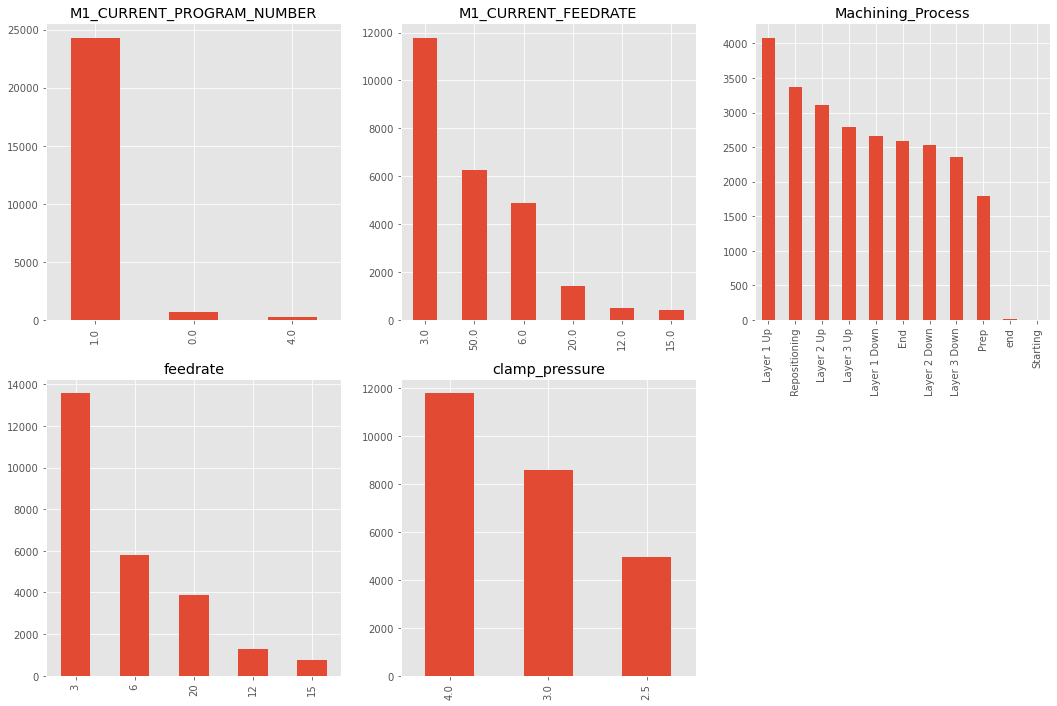

In [25]:
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
axs[1, 2].set_visible(False)

df_experiments['M1_CURRENT_PROGRAM_NUMBER'].value_counts().plot(kind='bar', title='M1_CURRENT_PROGRAM_NUMBER', ax=axs[0, 0])
df_experiments['M1_CURRENT_FEEDRATE'].value_counts().plot(kind='bar', title='M1_CURRENT_FEEDRATE', ax=axs[0, 1])
df_experiments['Machining_Process'].value_counts().plot(kind='bar', title='Machining_Process', ax=axs[0, 2])
df_experiments['feedrate'].value_counts().plot(kind='bar', title='feedrate', ax=axs[1, 0])
df_experiments['clamp_pressure'].value_counts().plot(kind='bar', title='clamp_pressure', ax=axs[1, 1])

<AxesSubplot:title={'center':'M1_sequence_number'}>

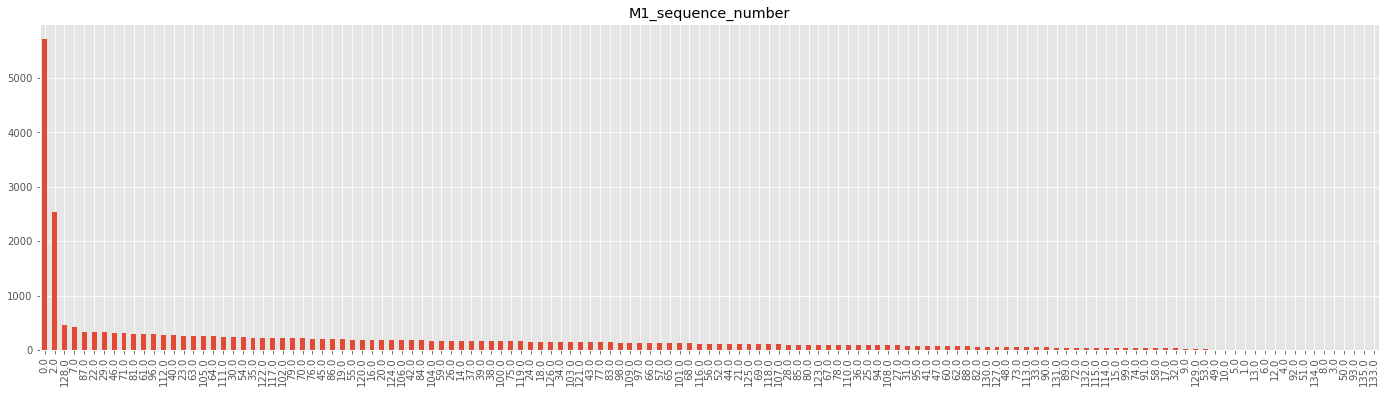

In [26]:
df_experiments['M1_sequence_number'].value_counts().plot(kind='bar', title='M1_sequence_number', figsize=(24, 6))

<AxesSubplot:>

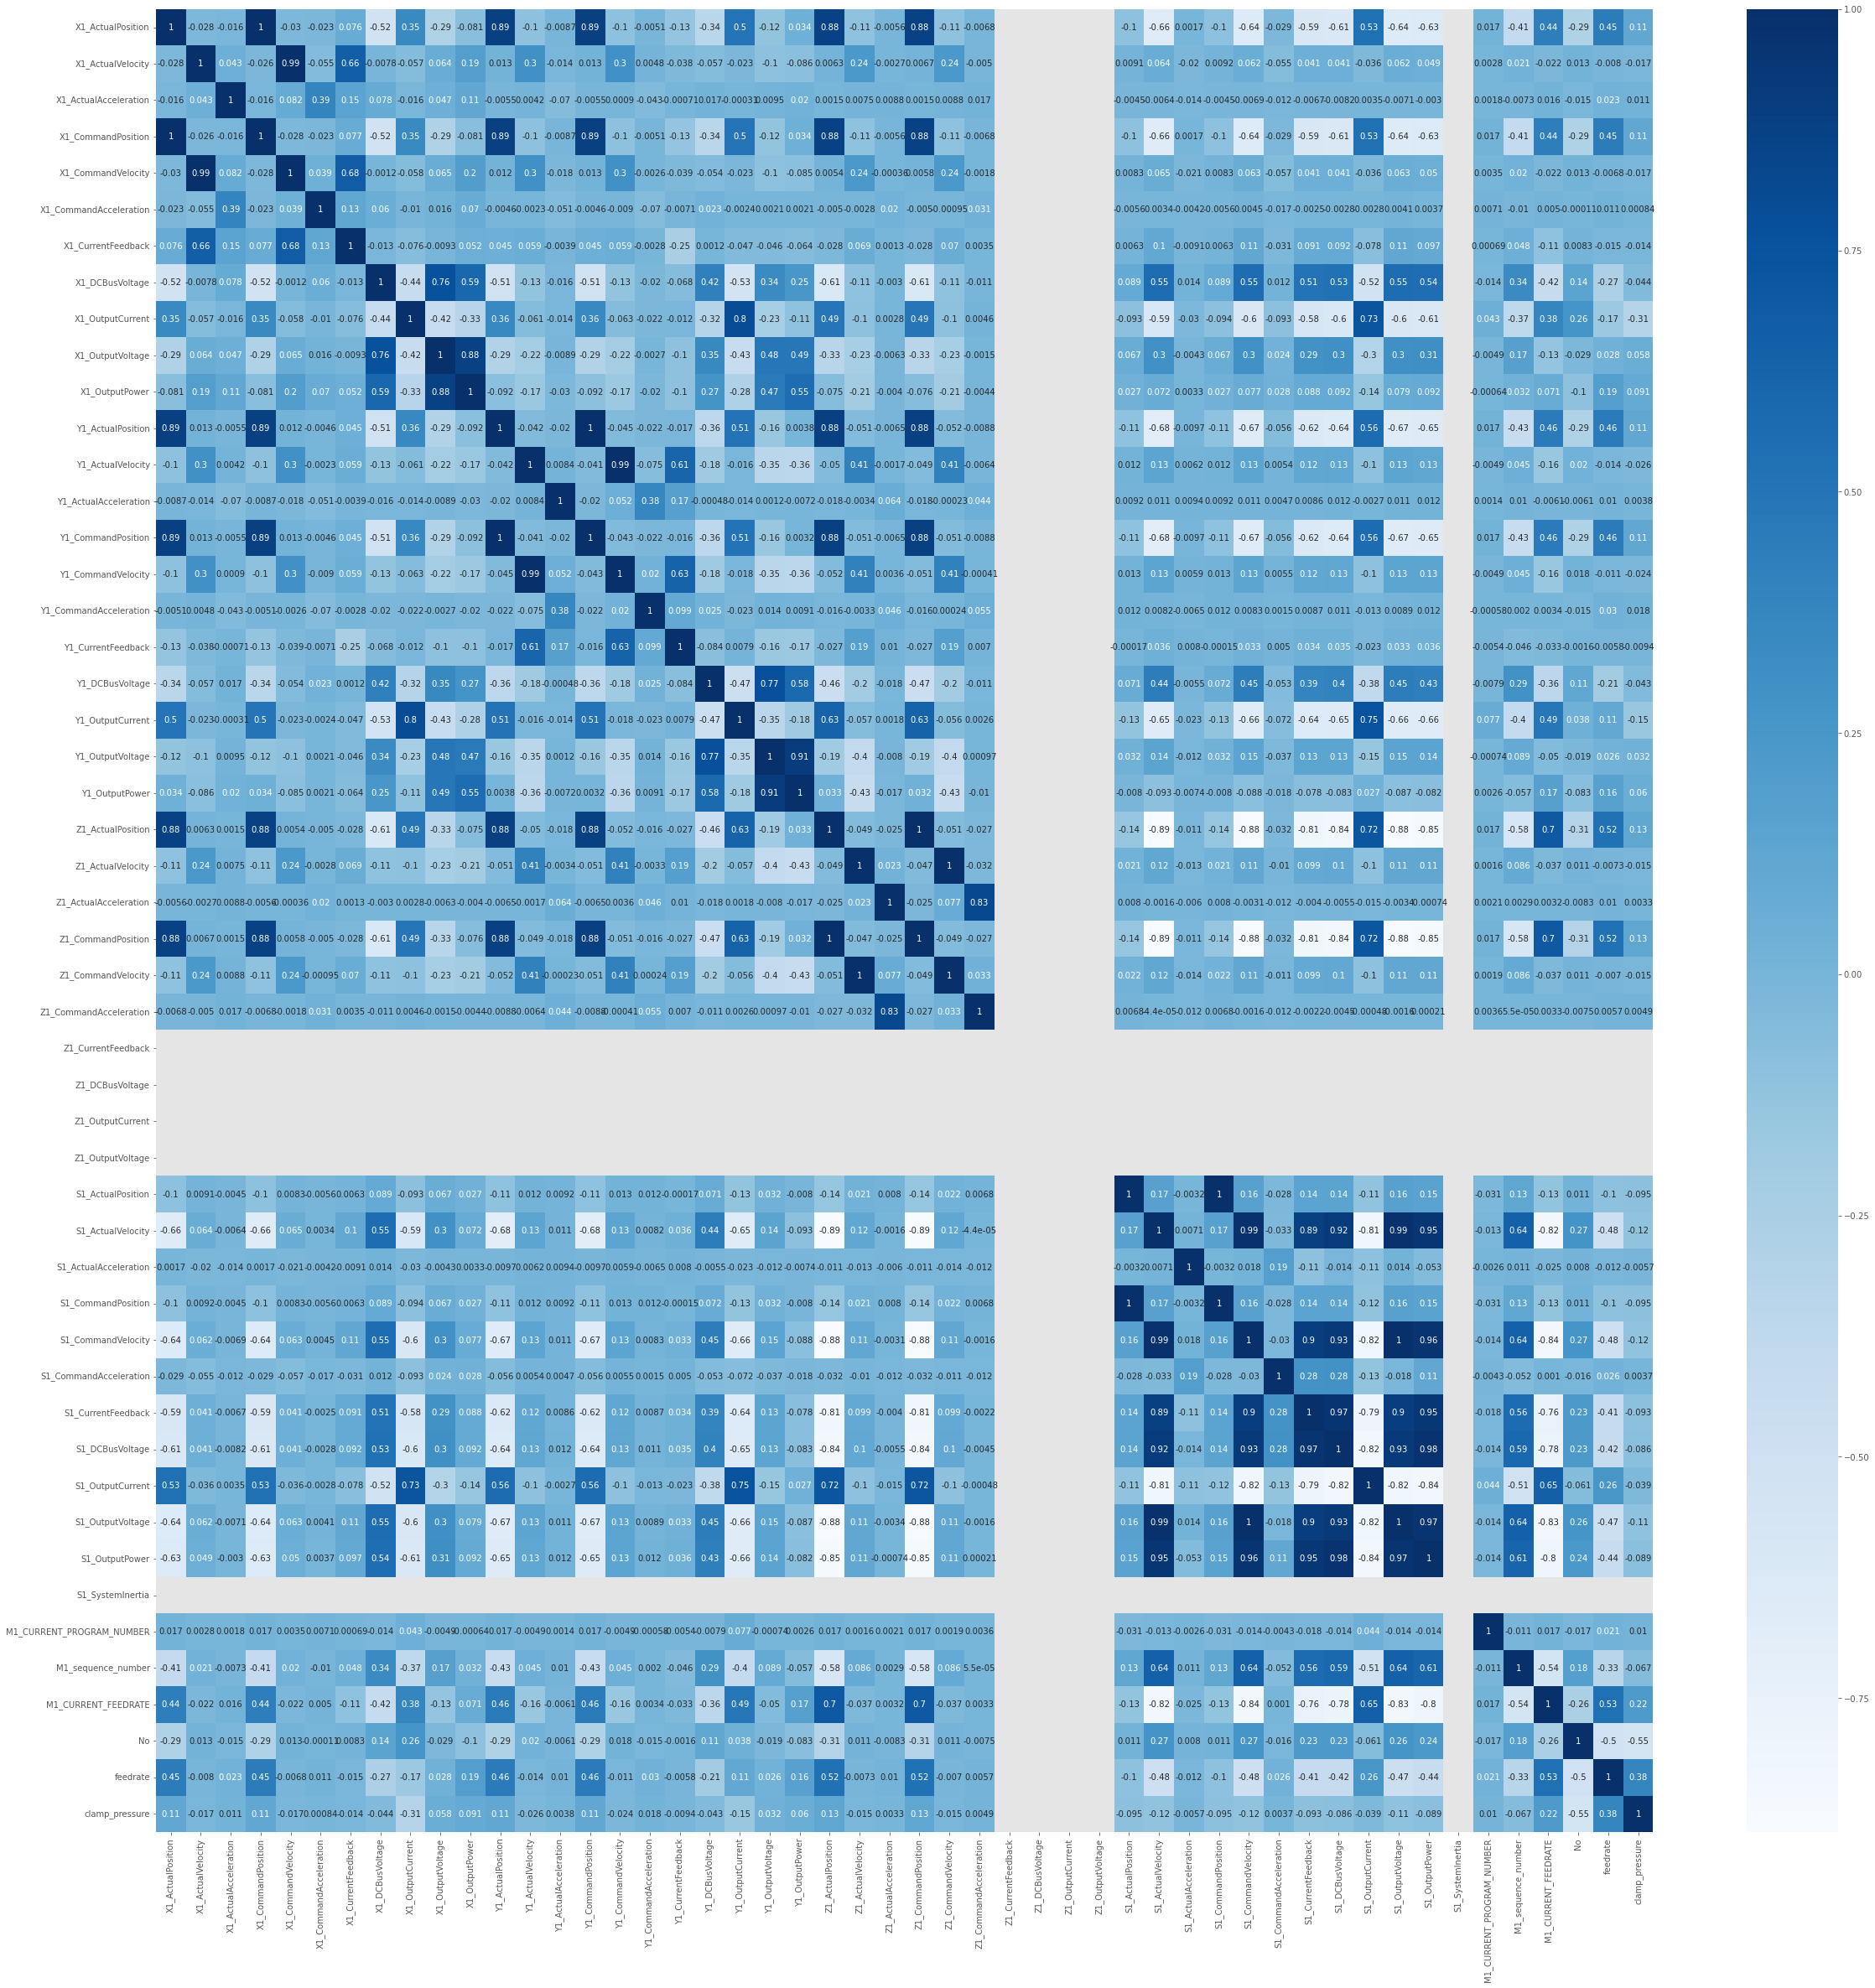

In [27]:
plt.figure(figsize=(40,40))

# Plot pairwise correlation for numerical columns
sns.heatmap(df_experiments.corr(),cbar=True,annot=True,cmap='Blues')

In [28]:
def plot_metrics(df: pd.DataFrame, experiment_ids: list, metric: str, color: str='#00FF00'):
    n_plots = len(experiment_ids)
    n_cols = 3
    n_rows = n_plots // n_cols + 1

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, 14))

    for i in range(n_plots):
        exp_id = experiment_ids[i]
        df_metric = df[df['No'] == exp_id].reset_index()[metric]
        df_metric.plot(kind='line',
                       title=f'{metric} in experiment {exp_id}',
                       color=color,
                       ax=axs[i//n_cols, i%n_cols])

In [29]:
# Graph various metrics by label and experiments 
agg = df_train_csv.groupby([LABEL_COL])['No'].apply(list)

print(agg)

worn_exp_ids = agg['worn']
unworn_exp_ids = agg['unworn']

tool_condition
unworn             [1, 2, 3, 4, 5, 11, 12, 17]
worn      [6, 7, 8, 9, 10, 13, 14, 15, 16, 18]
Name: No, dtype: object


### Actual Velocity

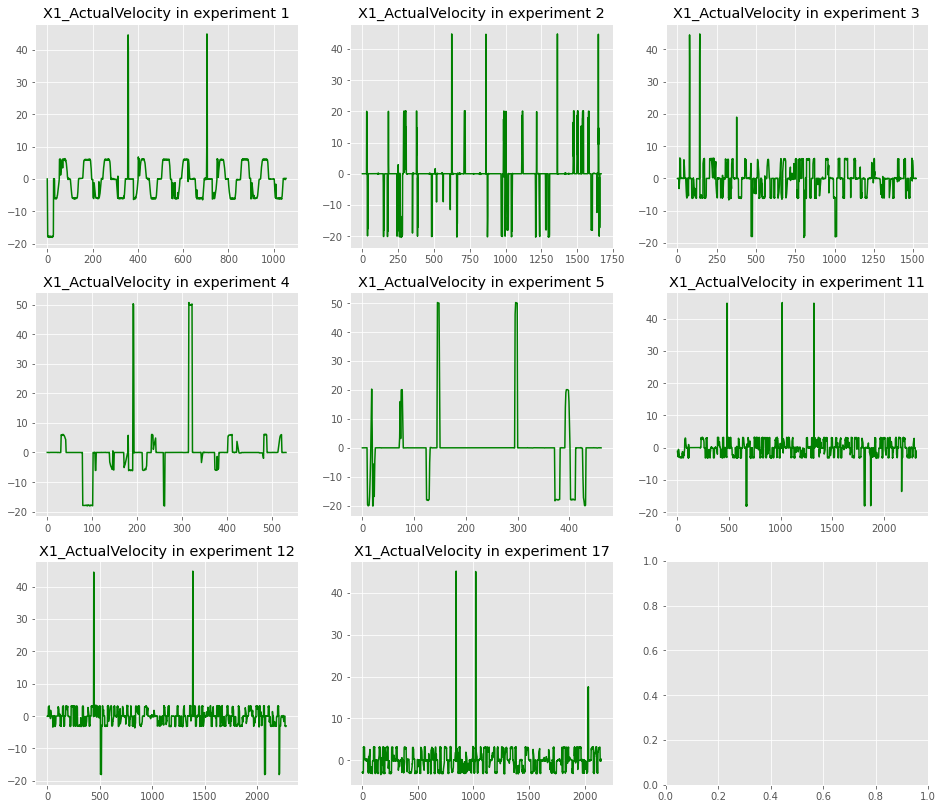

In [30]:
plot_metrics(df=df_experiments, experiment_ids=unworn_exp_ids, metric='X1_ActualVelocity', color='green')

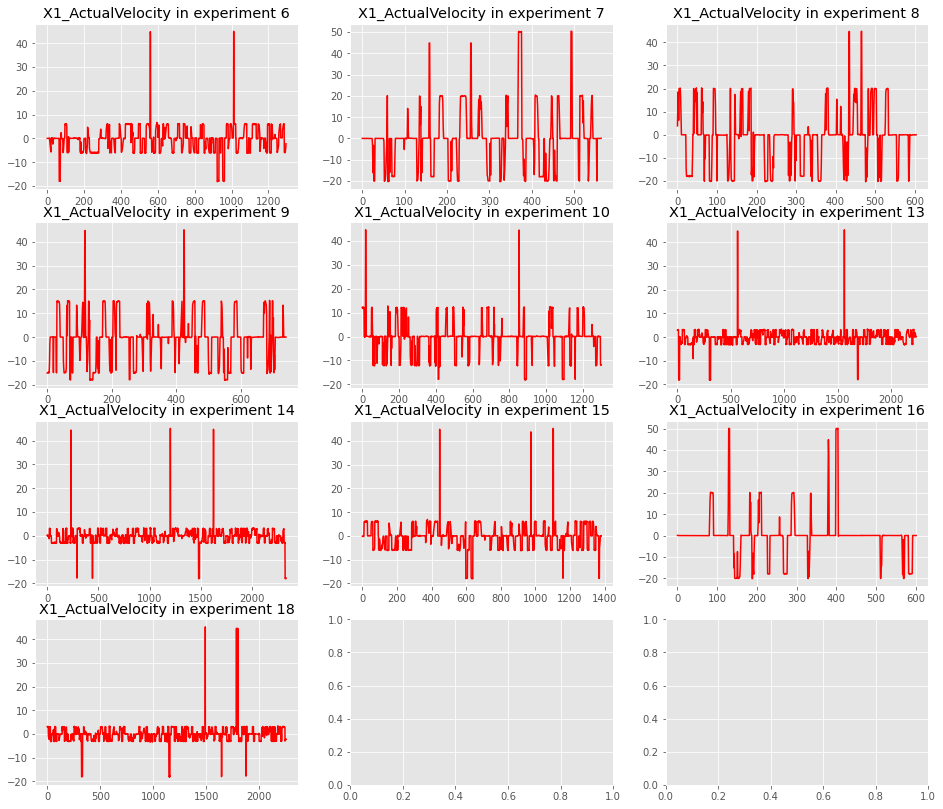

In [31]:
plot_metrics(df=df_experiments, experiment_ids=worn_exp_ids, metric='X1_ActualVelocity', color='red')

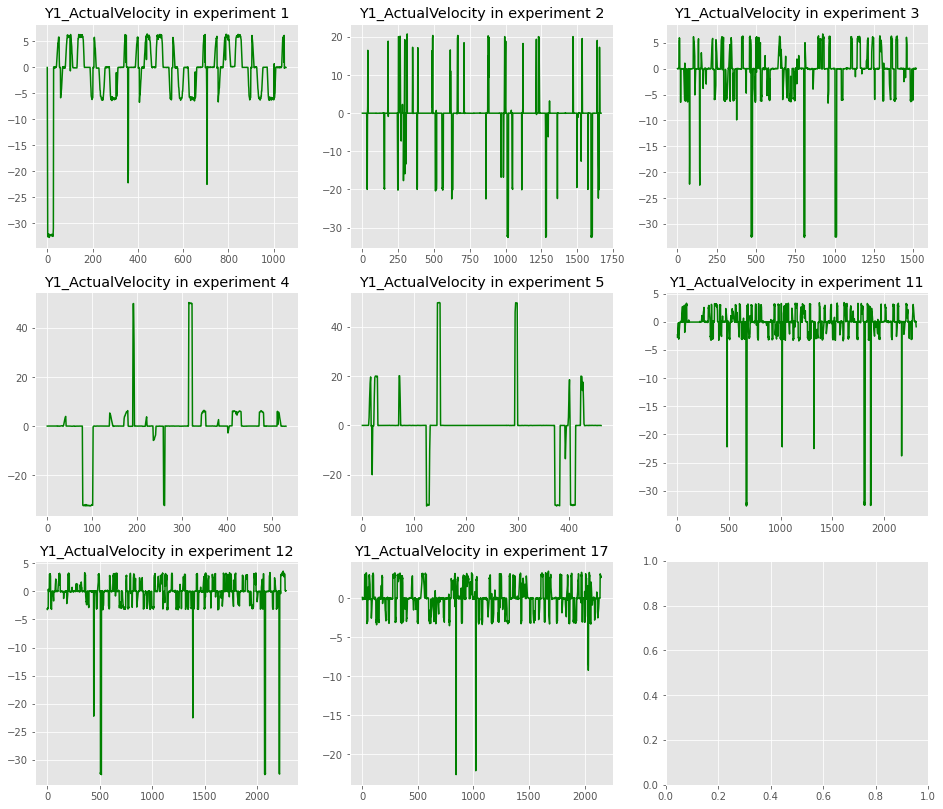

In [32]:
plot_metrics(df=df_experiments, experiment_ids=unworn_exp_ids, metric='Y1_ActualVelocity', color='green')

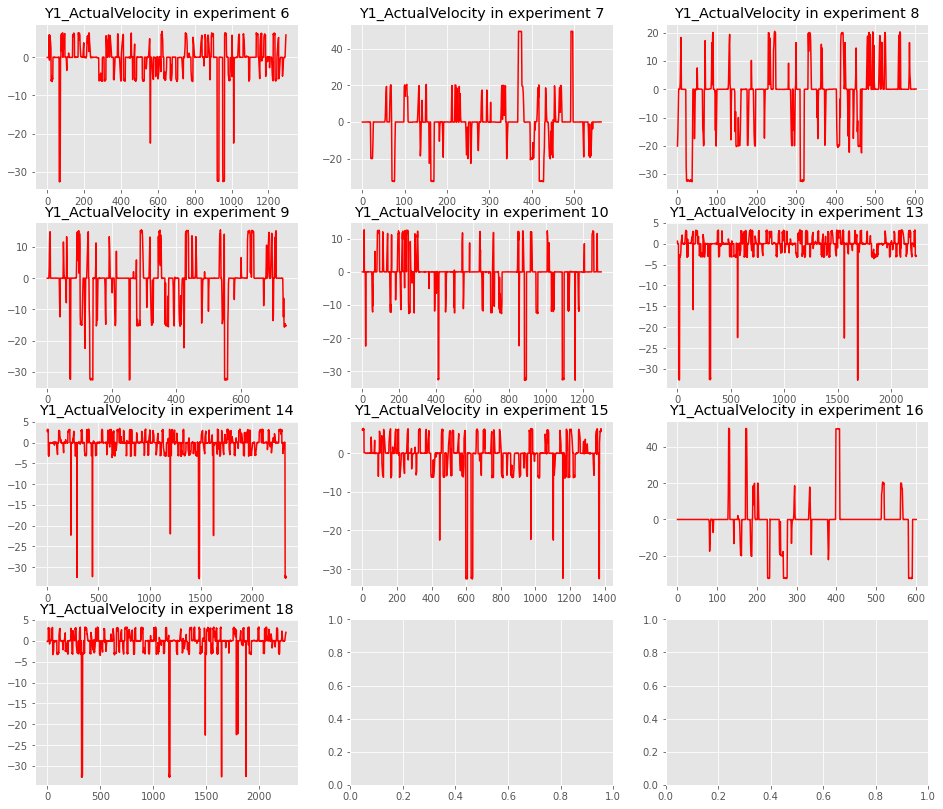

In [33]:
plot_metrics(df=df_experiments, experiment_ids=worn_exp_ids, metric='Y1_ActualVelocity', color='red')

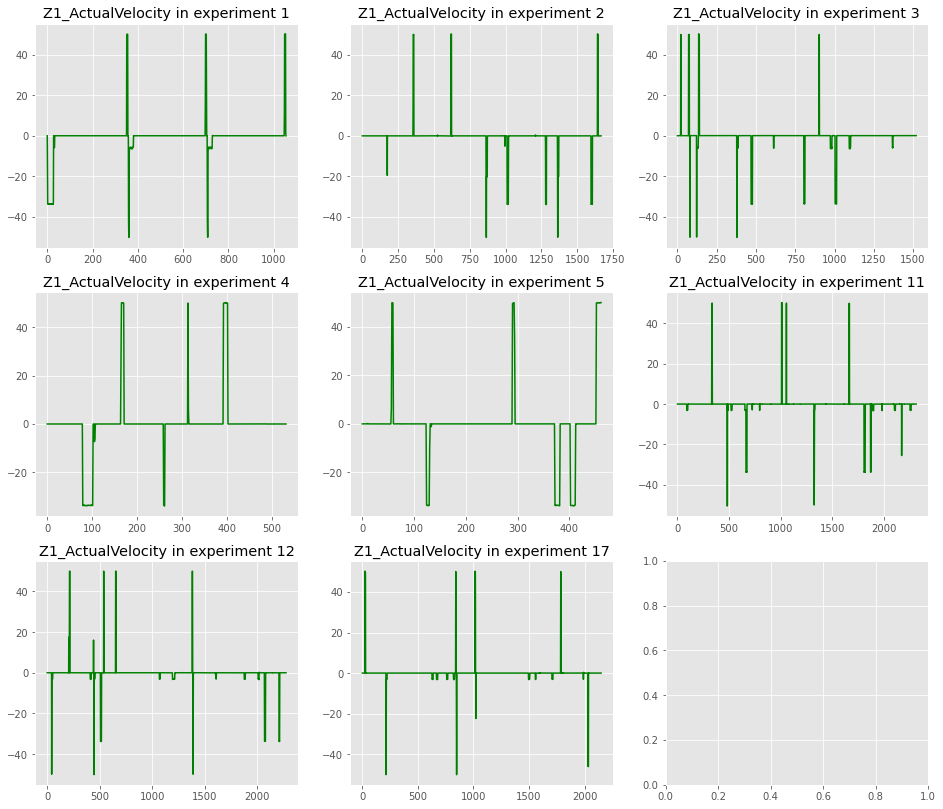

In [34]:
plot_metrics(df=df_experiments, experiment_ids=unworn_exp_ids, metric='Z1_ActualVelocity', color='green')

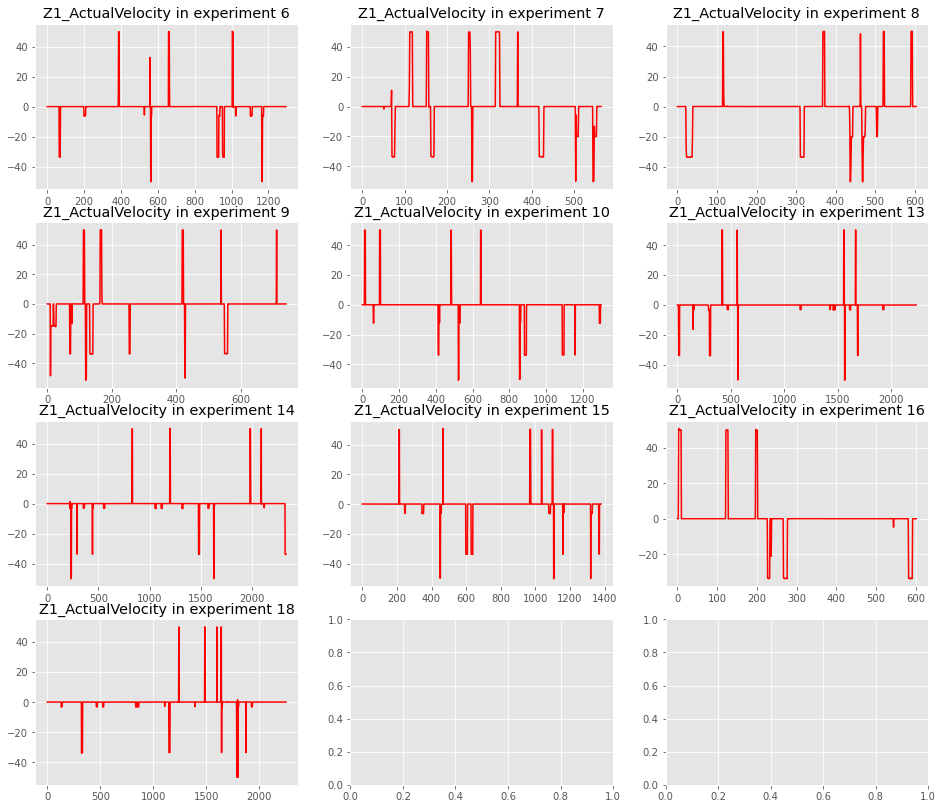

In [35]:
plot_metrics(df=df_experiments, experiment_ids=worn_exp_ids, metric='Z1_ActualVelocity', color='red')

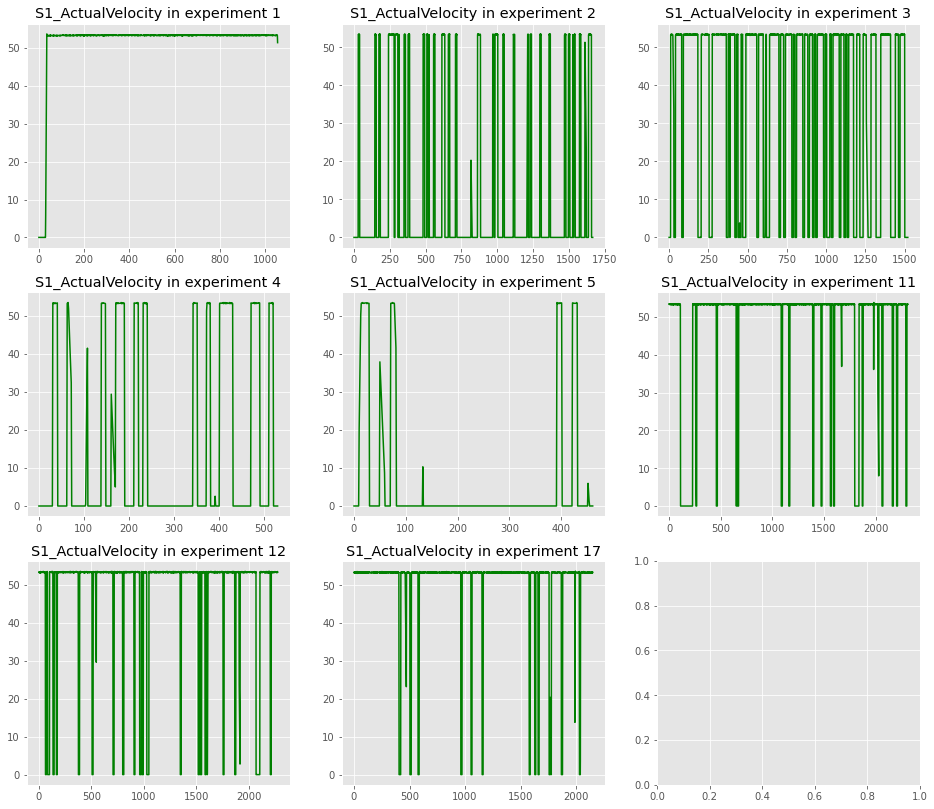

In [36]:
plot_metrics(df=df_experiments, experiment_ids=unworn_exp_ids, metric='S1_ActualVelocity', color='green')

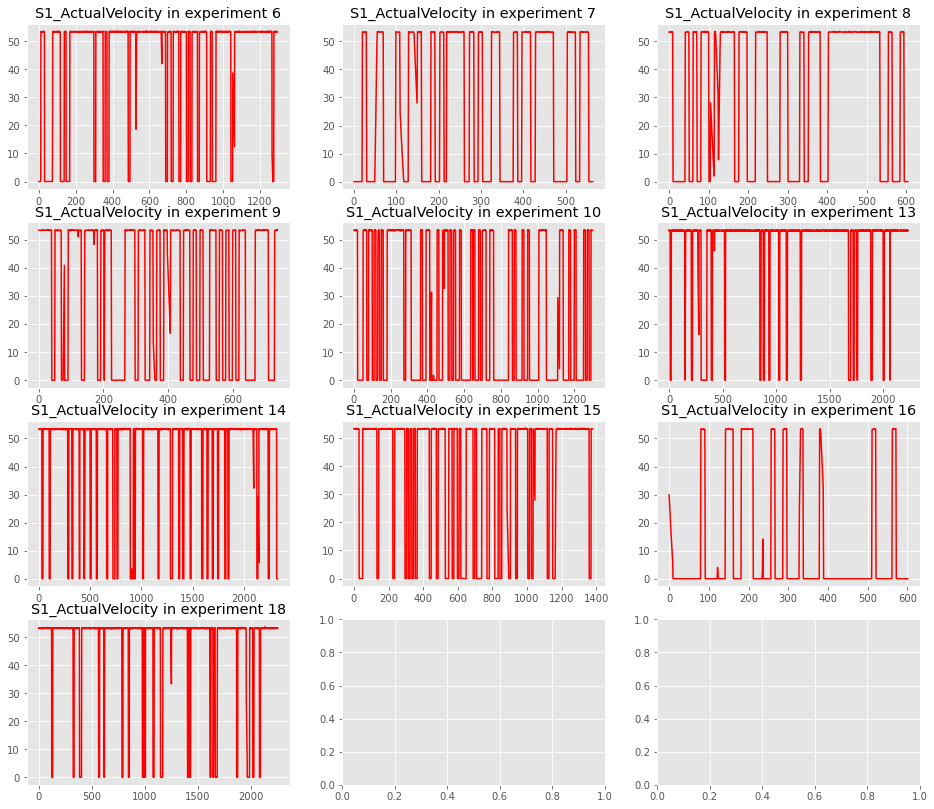

In [37]:
plot_metrics(df=df_experiments, experiment_ids=worn_exp_ids, metric='S1_ActualVelocity', color='red')

### Actual Position

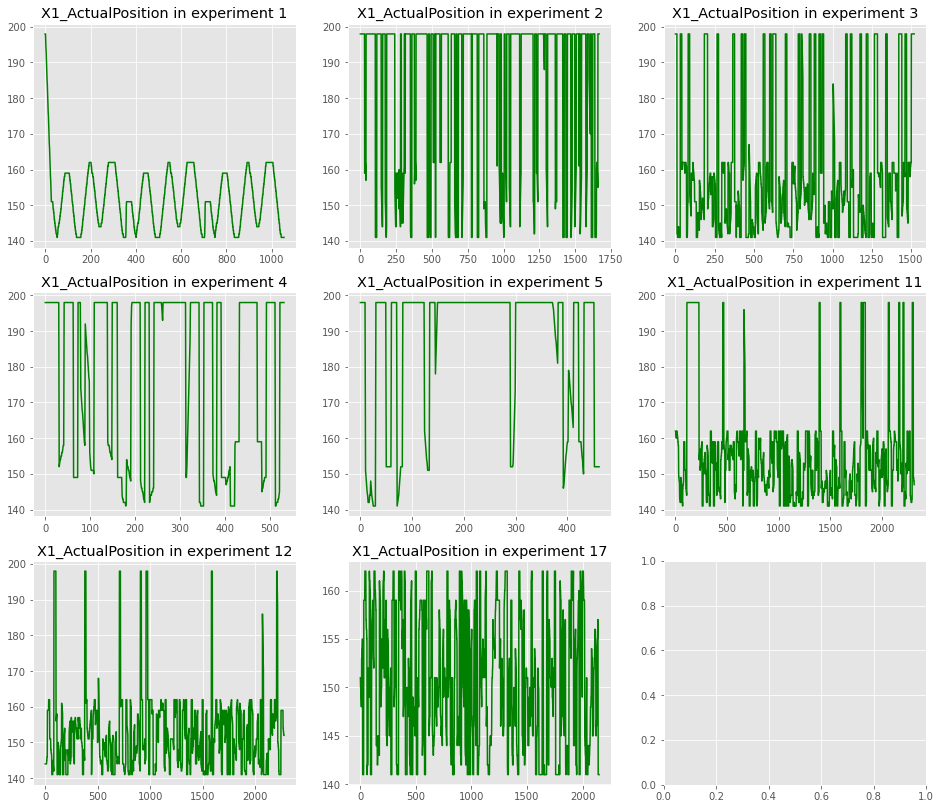

In [38]:
plot_metrics(df=df_experiments, experiment_ids=unworn_exp_ids, metric='X1_ActualPosition', color='green')

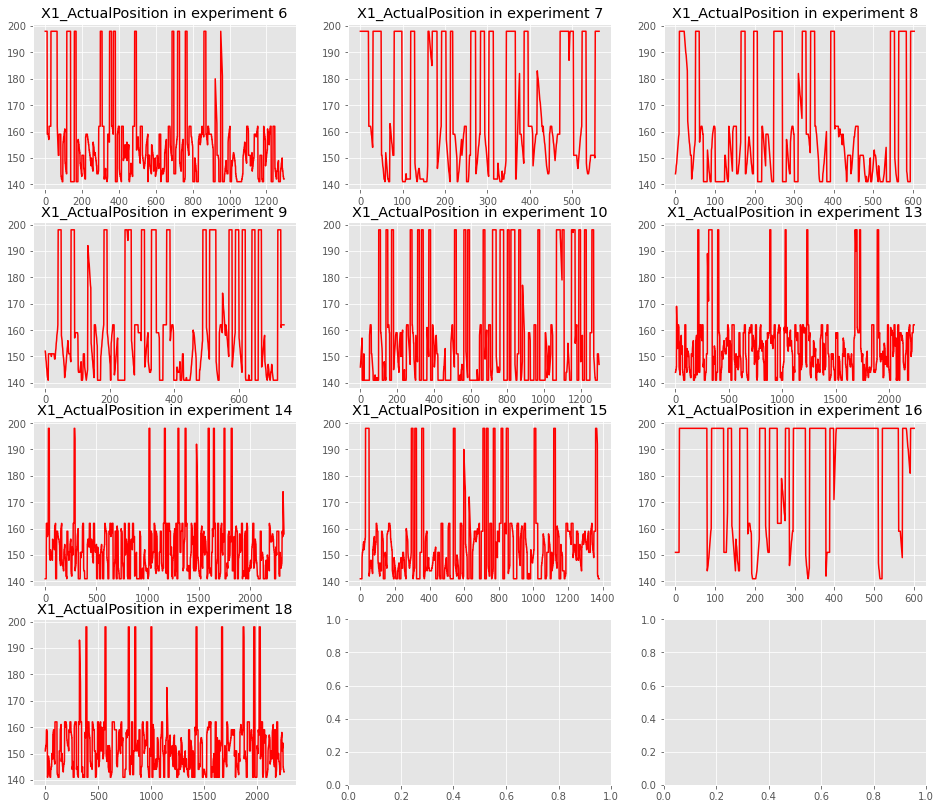

In [39]:
plot_metrics(df=df_experiments, experiment_ids=worn_exp_ids, metric='X1_ActualPosition', color='red')

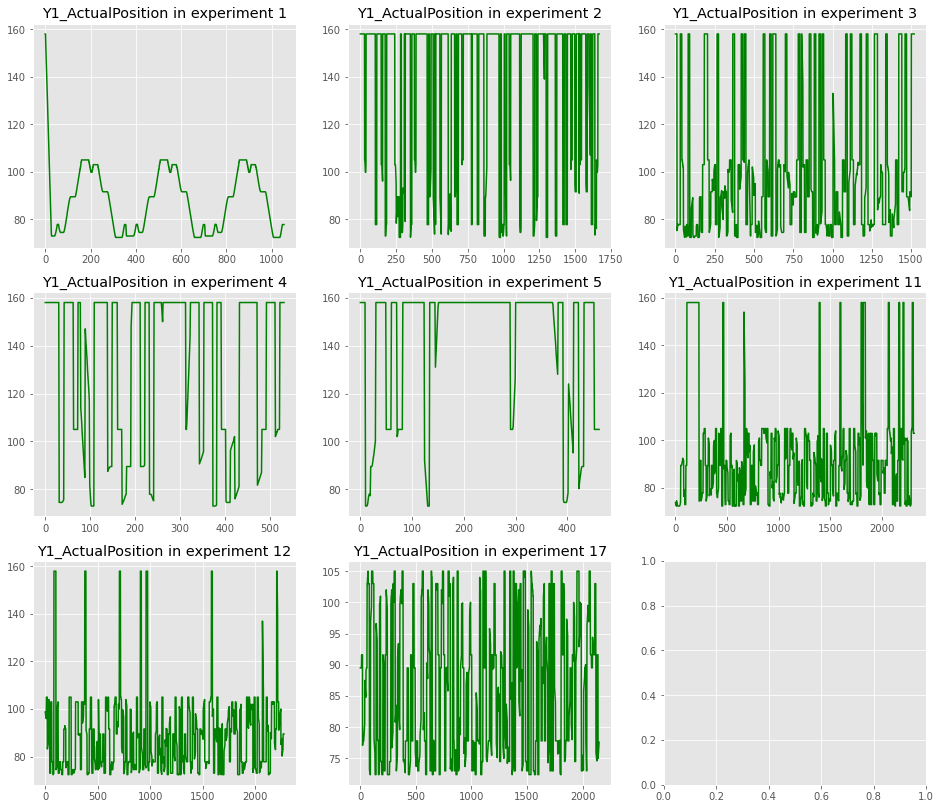

In [40]:
plot_metrics(df=df_experiments, experiment_ids=unworn_exp_ids, metric='Y1_ActualPosition', color='green')

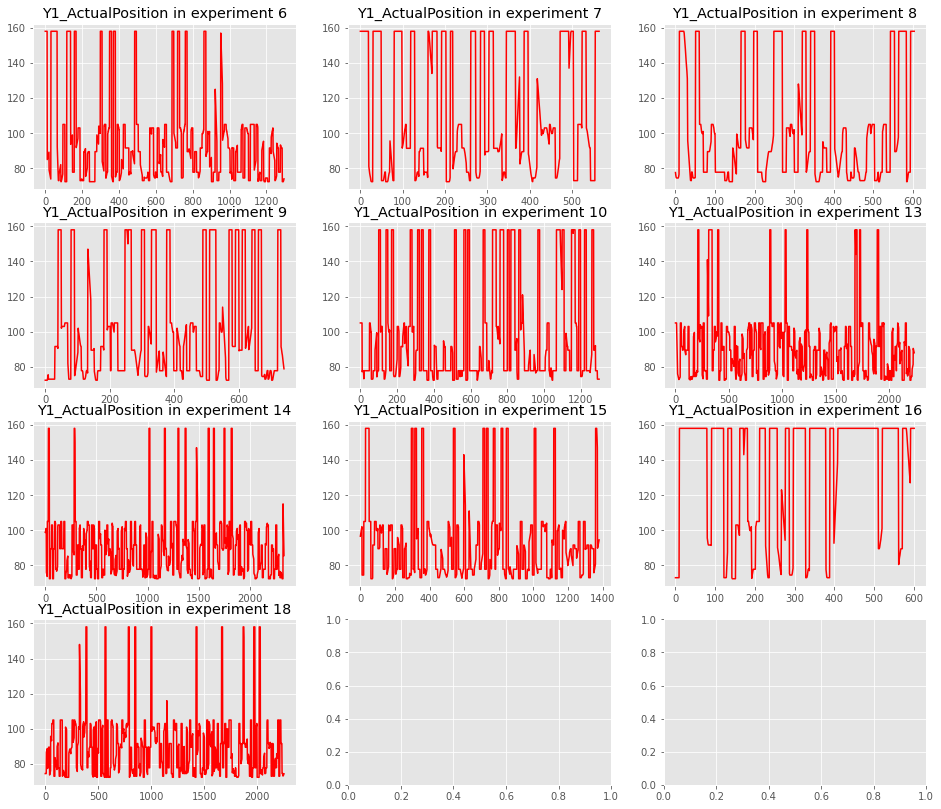

In [41]:
plot_metrics(df=df_experiments, experiment_ids=worn_exp_ids, metric='Y1_ActualPosition', color='red')

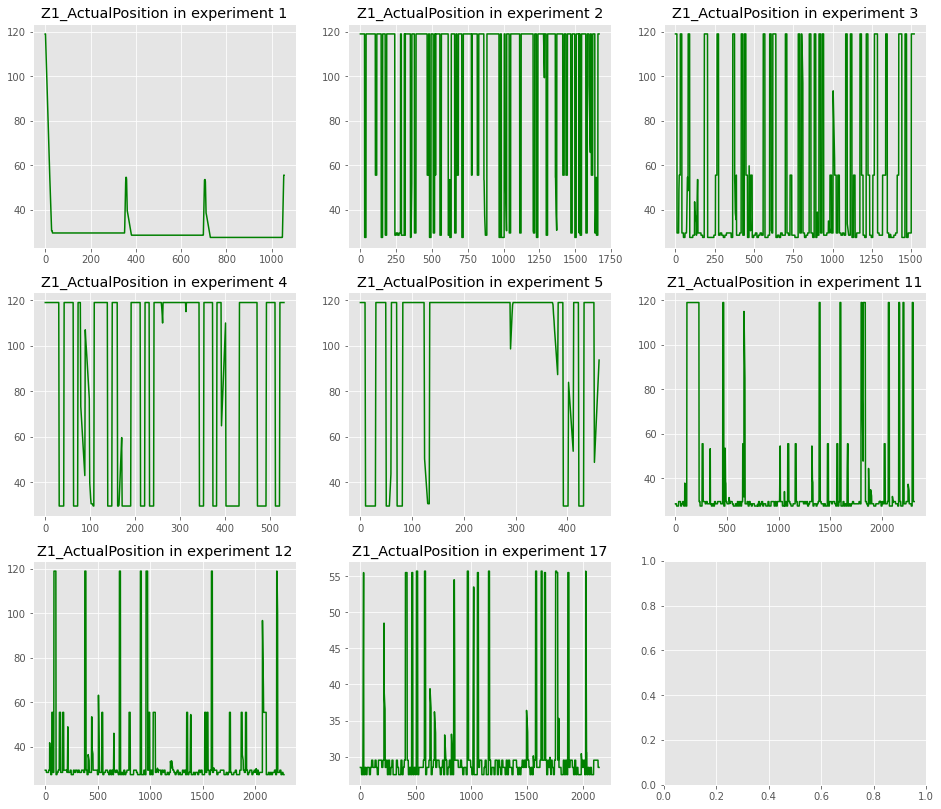

In [42]:
plot_metrics(df=df_experiments, experiment_ids=unworn_exp_ids, metric='Z1_ActualPosition', color='green')

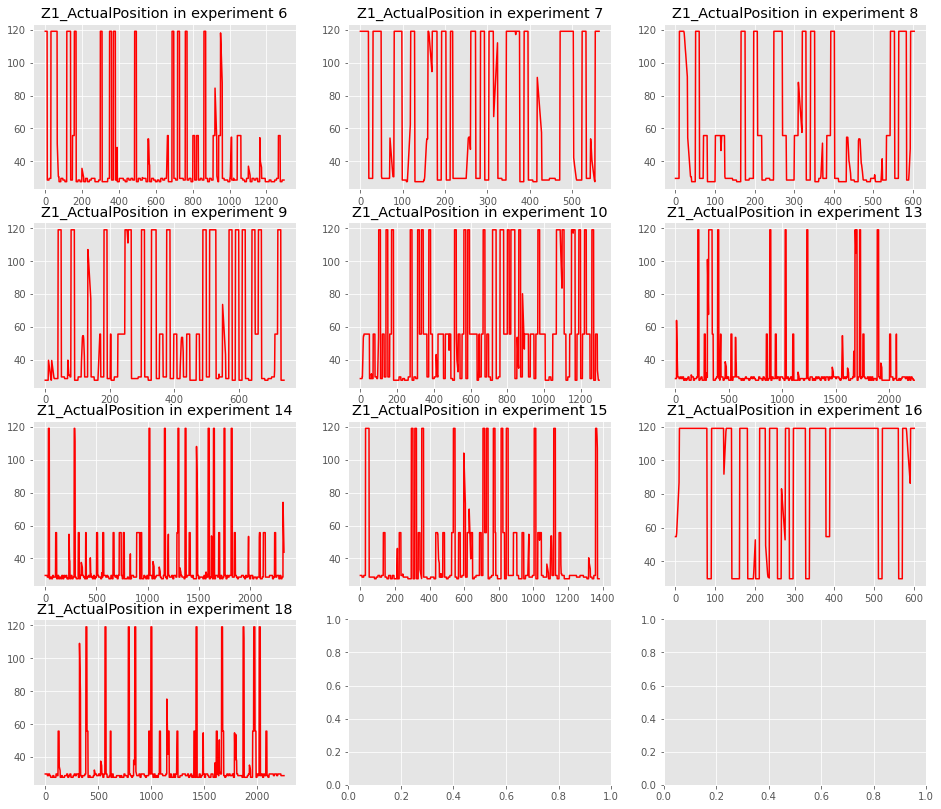

In [43]:
plot_metrics(df=df_experiments, experiment_ids=worn_exp_ids, metric='Z1_ActualPosition', color='red')

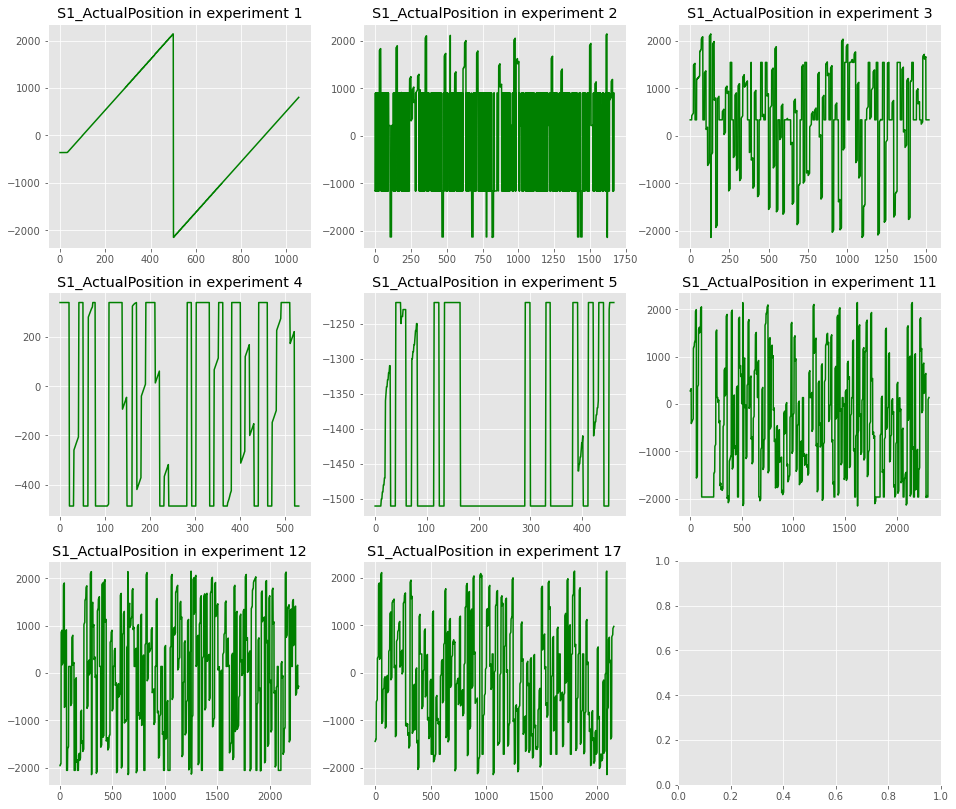

In [44]:
plot_metrics(df=df_experiments, experiment_ids=unworn_exp_ids, metric='S1_ActualPosition', color='green')

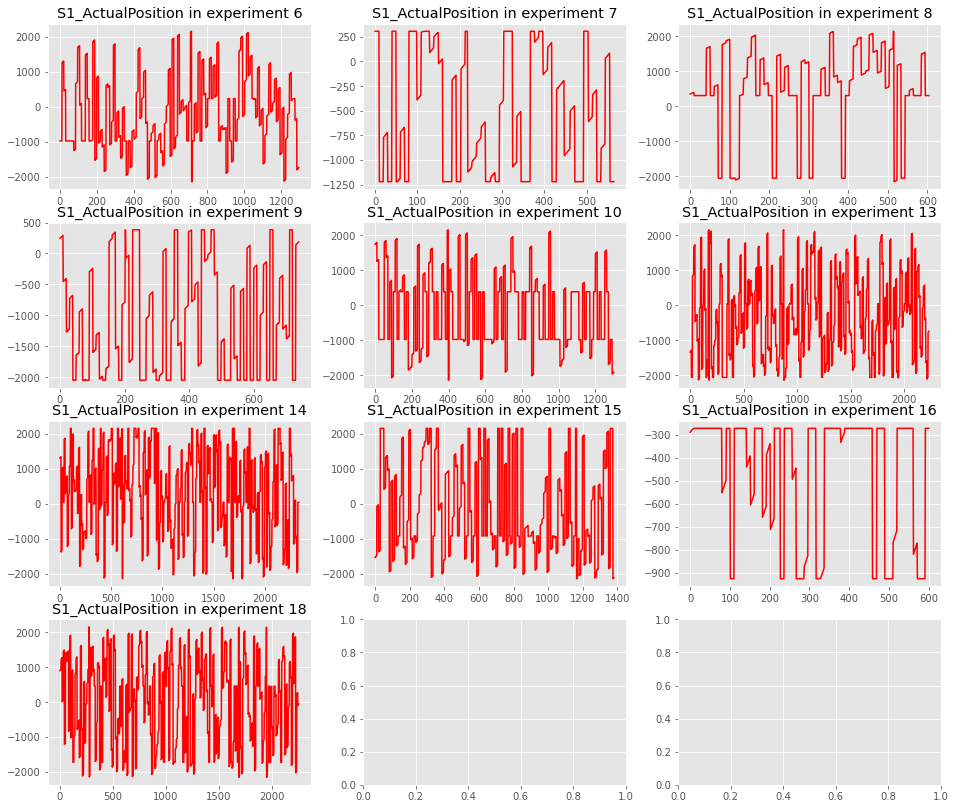

In [45]:
plot_metrics(df=df_experiments, experiment_ids=worn_exp_ids, metric='S1_ActualPosition', color='red')

### EDA Summary

1. There are some feature columns (e.g. `Z1_CurrentFeedback`,`Z1_CommandVelocity`) with high percentage of zeros. 
1. The number of data points across `worn` (i.e. 13308) and `unworn` (i.e. 11978) classes are relatively balanced. 
1. There are many columns that have high correlation
    - Across X / Y / Z / S
        - `*_ActualPosition` & `*_CommandPosition`
        - `*_ActualVelocity` & `*_CommandVelocity`
        - `*_DCBusVoltage` & `*_OutputCurrent` & `*_OutputVoltage` & `*_OutputPower`
    - `{X,Y,Z}_*Positions` have negative correlation with `S1_{ActualVelocity,CurrentFeedback,DCBusVoltage,OutputVoltage,OutputPower}`

1. It is not intuitive to reason across telemetries (e.g. `*_ActualVelocity`, `*_ActualPosition`) between worn and unworn classes. 


## Data Processing

### Avoid Data Leakage

https://cloud.google.com/vertex-ai/docs/datasets/bp-tabular#target-leakage

TODO: understand when CNC mill tools are replaced. In between product production or whenever CNC mill is predicted to be worn.

In [46]:
COL_TO_EXCLUDE = ['machining_finalized', 'passed_visual_inspection']

df_experiments.drop(columns=COL_TO_EXCLUDE, inplace=True, errors='ignore')

### Clean Up Machining Process Category

https://cloud.google.com/vertex-ai/docs/datasets/bp-tabular#make_sure_your_categorical_features_are_accurate_and_clean

In [47]:
df_experiments['Machining_Process'].value_counts()

Layer 1 Up       4085
Repositioning    3377
Layer 2 Up       3104
Layer 3 Up       2794
Layer 1 Down     2655
End              2585
Layer 2 Down     2528
Layer 3 Down     2354
Prep             1795
end                 8
Starting            1
Name: Machining_Process, dtype: int64

#### Machining Process Observations

Notice the values `End` and `end` represents the same process, but have different capitalization. This will cause [AutoML](https://cloud.google.com/vertex-ai/docs/datasets/data-types-tabular#categorical-transf) to treat these as different values. Hence, we will relabel the value `end` to `End`. 

In addition, notice that `Starting` value only has 1 count. There isn't sufficient data points to provide insights on the `Starting` process and may confuse the model prediction. Hence, we will group `Starting` and `Prep` together.

In [48]:
df_experiments.replace(
    {'Machining_Process': {'Starting': 'Prep', 'end': 'End'}},
    inplace=True
)

df_experiments['Machining_Process'].value_counts()

Layer 1 Up       4085
Repositioning    3377
Layer 2 Up       3104
Layer 3 Up       2794
Layer 1 Down     2655
End              2593
Layer 2 Down     2528
Layer 3 Down     2354
Prep             1796
Name: Machining_Process, dtype: int64

In [49]:
# Replace machining process value with int because MCe simulator can only simulate bit / int / float
machining_process_dict = {
    'Machining_Process': {
        'Starting': 1,
        'Prep': 1,
        'Layer 1 Up': 2,
        'Layer 1 Down': 3,
        'Layer 2 Up': 4,
        'Layer 2 Down': 5,
        'Layer 3 Up': 6,
        'Layer 3 Down': 7,
        'Repositioning': 8,
        'End': 9,
        'end': 9,
    }
}

df_experiments.replace(machining_process_dict, inplace=True)

## Feature Engineering

In [50]:
# TODO: Calculate difference between command and actual metrics AND FFT as features

In [51]:
for ax in ['X','Y','Z','S']:
    df_experiments[f'{ax}1_PositionDiff'] = abs(df_experiments[f'{ax}1_CommandPosition']-df_experiments[f'{ax}1_ActualPosition'])
    df_experiments[f'{ax}1_VelocityDiff'] = abs(df_experiments[f'{ax}1_CommandVelocity']-df_experiments[f'{ax}1_ActualVelocity'])
    df_experiments[f'{ax}1_AccelerationDiff'] = abs(df_experiments[f'{ax}1_CommandAcceleration']-df_experiments[f'{ax}1_ActualAcceleration'])

## Train Test Split

In [54]:
df_experiment_2_holdout = df_experiments[df_experiments['No'] == 2].iloc[-500:]
df_experiment_13_holdout = df_experiments[df_experiments['No'] == 13].iloc[-500:]
indices_exclude = list(df_experiment_2_holdout.index) + list(df_experiment_13_holdout.index)

# df_experiments.drop(index=indices_exclude, inplace=True)

df_experiment_holdout = pd.concat(
    [df_experiment_2_holdout, df_experiment_13_holdout],
    axis=0,
    ignore_index=True
)

dataset_bucket_uri = f'{BUCKET_URI}/{VERTEX_AI_PREFIX}_holdout.json'

df_experiment_holdout.drop(columns=['No'], errors='ignore', inplace=True)
df_experiment_holdout.to_json(dataset_bucket_uri, orient='records')

In [55]:
# Exp 1: unworn, finalized, pass
# Exp 4: unworn, not finalized, no pass
# Exp 7: worn, not finalized, no pass
# Exp 8: worn, not finalized, no pass
# Exp 15: worn, finalized, pass
test_experiment_ids = [1, 4, 7, 8, 15]

df_experiments[SPLIT_COL] = 'UNASSIGNED'
df_experiments.loc[df_experiments['No'].isin(test_experiment_ids), SPLIT_COL] = 'TEST'
df_experiments[SPLIT_COL].value_counts()

UNASSIGNED    21148
TEST           4138
Name: ml_use, dtype: int64

## Data Output

In [56]:
# Drop experiment id column
df_experiments_out = df_experiments.drop(columns=['No'], errors='ignore')
dataset_bucket_uri = f'{BUCKET_URI}/{VERTEX_AI_PREFIX}.csv'

df_experiments_out.to_csv(dataset_bucket_uri, index=False)

## Vertex AI

In [57]:
# Create a Vertex AI dataset
dataset = vertex_ai.TabularDataset.create(
    display_name=VERTEX_AI_PREFIX,
    gcs_source=dataset_bucket_uri,
)

print(dataset.resource_name)

Creating TabularDataset
Create TabularDataset backing LRO: projects/944080718770/locations/us-central1/datasets/3687711422025826304/operations/4645872377555582976
TabularDataset created. Resource name: projects/944080718770/locations/us-central1/datasets/3687711422025826304
To use this TabularDataset in another session:
ds = aiplatform.TabularDataset('projects/944080718770/locations/us-central1/datasets/3687711422025826304')
projects/944080718770/locations/us-central1/datasets/3687711422025826304


In [58]:
TRANSFORMATION = [
    {'numeric': {'column_name': 'X1_ActualPosition'}},
    {'numeric': {'column_name': 'X1_ActualVelocity'}},
    {'numeric': {'column_name': 'X1_ActualAcceleration'}},
    {'numeric': {'column_name': 'X1_CommandPosition'}},
    {'numeric': {'column_name': 'X1_CommandVelocity'}},
    {'numeric': {'column_name': 'X1_CommandAcceleration'}},
    {'numeric': {'column_name': 'X1_CurrentFeedback'}},
    {'numeric': {'column_name': 'X1_DCBusVoltage'}},
    {'numeric': {'column_name': 'X1_OutputCurrent'}},
    {'numeric': {'column_name': 'X1_OutputVoltage'}},
    {'numeric': {'column_name': 'X1_OutputPower'}},
    {'numeric': {'column_name': 'Y1_ActualPosition'}},
    {'numeric': {'column_name': 'Y1_ActualVelocity'}},
    {'numeric': {'column_name': 'Y1_ActualAcceleration'}},
    {'numeric': {'column_name': 'Y1_CommandPosition'}},
    {'numeric': {'column_name': 'Y1_CommandVelocity'}},
    {'numeric': {'column_name': 'Y1_CommandAcceleration'}},
    {'numeric': {'column_name': 'Y1_CurrentFeedback'}},
    {'numeric': {'column_name': 'Y1_DCBusVoltage'}},
    {'numeric': {'column_name': 'Y1_OutputCurrent'}},
    {'numeric': {'column_name': 'Y1_OutputVoltage'}},
    {'numeric': {'column_name': 'Y1_OutputPower'}},
    {'numeric': {'column_name': 'Z1_ActualPosition'}},
    {'numeric': {'column_name': 'Z1_ActualVelocity'}},
    {'numeric': {'column_name': 'Z1_ActualAcceleration'}},
    {'numeric': {'column_name': 'Z1_CommandPosition'}},
    {'numeric': {'column_name': 'Z1_CommandVelocity'}},
    {'numeric': {'column_name': 'Z1_CommandAcceleration'}},
    {'numeric': {'column_name': 'Z1_CurrentFeedback'}},
    {'numeric': {'column_name': 'Z1_DCBusVoltage'}},
    {'numeric': {'column_name': 'Z1_OutputCurrent'}},
    {'numeric': {'column_name': 'Z1_OutputVoltage'}},
    {'numeric': {'column_name': 'S1_ActualPosition'}},
    {'numeric': {'column_name': 'S1_ActualVelocity'}},
    {'numeric': {'column_name': 'S1_ActualAcceleration'}},
    {'numeric': {'column_name': 'S1_CommandPosition'}},
    {'numeric': {'column_name': 'S1_CommandVelocity'}},
    {'numeric': {'column_name': 'S1_CommandAcceleration'}},
    {'numeric': {'column_name': 'S1_CurrentFeedback'}},
    {'numeric': {'column_name': 'S1_DCBusVoltage'}},
    {'numeric': {'column_name': 'S1_OutputCurrent'}},
    {'numeric': {'column_name': 'S1_OutputVoltage'}},
    {'numeric': {'column_name': 'S1_OutputPower'}},
    {'numeric': {'column_name': 'S1_SystemInertia'}},
    {'categorical': {'column_name': 'M1_CURRENT_PROGRAM_NUMBER'}},
    {'categorical': {'column_name': 'M1_sequence_number'}},
    {'numeric': {'column_name': 'M1_CURRENT_FEEDRATE'}},
    {'categorical': {'column_name': 'Machining_Process'}},
    {'categorical': {'column_name': 'material'}},
    {'numeric': {'column_name': 'feedrate'}},
    {'numeric': {'column_name': 'clamp_pressure'}},
    {'categorical': {'column_name': 'tool_condition'}},
    {'numeric': {'column_name': 'X1_PositionDiff'}},
    {'numeric': {'column_name': 'X1_VelocityDiff'}},
    {'numeric': {'column_name': 'X1_AccelerationDiff'}},
    {'numeric': {'column_name': 'Y1_PositionDiff'}},
    {'numeric': {'column_name': 'Y1_VelocityDiff'}},
    {'numeric': {'column_name': 'Y1_AccelerationDiff'}},
    {'numeric': {'column_name': 'Z1_PositionDiff'}},
    {'numeric': {'column_name': 'Z1_VelocityDiff'}},
    {'numeric': {'column_name': 'Z1_AccelerationDiff'}},
    {'numeric': {'column_name': 'S1_PositionDiff'}},
    {'numeric': {'column_name': 'S1_VelocityDiff'}},
    {'numeric': {'column_name': 'S1_AccelerationDiff'}},
    {'categorical': {'column_name': 'ml_use'}}
]

In [59]:
# Create a Vertex AI AutoML job
dag = vertex_ai.AutoMLTabularTrainingJob(
    display_name=VERTEX_AI_PREFIX,
    optimization_prediction_type="classification",
    optimization_objective="maximize-au-roc",
    column_transformations=TRANSFORMATION,
)

print(dag)

model = dag.run(
    dataset=dataset,
    model_display_name=VERTEX_AI_PREFIX,
    predefined_split_column_name=SPLIT_COL,
    budget_milli_node_hours=1000,
    disable_early_stopping=False,
    target_column=LABEL_COL,
)

/opt/conda/lib/python3.7/site-packages/google/cloud/aiplatform/training_jobs.py:4563: DeprecationWarning: consider using column_specs instead. column_transformations will be deprecated in the future.
  column_specs, column_transformations


View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/1305985892699078656?project=944080718770
AutoMLTabularTrainingJob projects/944080718770/locations/us-central1/trainingPipelines/1305985892699078656 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLTabularTrainingJob projects/944080718770/locations/us-central1/trainingPipelines/1305985892699078656 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLTabularTrainingJob projects/944080718770/locations/us-central1/trainingPipelines/1305985892699078656 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLTabularTrainingJob projects/944080718770/locations/us-central1/trainingPipelines/1305985892699078656 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLTabularTrainingJob projects/944080718770/locations/us-central1/trainingPipelines/1305985892699078656 current state:
PipelineState.PIPELINE_STATE_RUNNING
AutoMLTabularTrainingJob projects/944080718770/locations/us-central1/trai

In [60]:
endpoint = model.deploy(machine_type='n1-standard-2',)

Creating Endpoint
Create Endpoint backing LRO: projects/944080718770/locations/us-central1/endpoints/2531436406954262528/operations/5176171233678458880
Endpoint created. Resource name: projects/944080718770/locations/us-central1/endpoints/2531436406954262528
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/944080718770/locations/us-central1/endpoints/2531436406954262528')
Deploying model to Endpoint : projects/944080718770/locations/us-central1/endpoints/2531436406954262528
Deploy Endpoint model backing LRO: projects/944080718770/locations/us-central1/endpoints/2531436406954262528/operations/8209345582712487936
Endpoint model deployed. Resource name: projects/944080718770/locations/us-central1/endpoints/2531436406954262528


In [61]:
def top_k_feature_attributions(explanations, k=5):
    feat_attr = list(explanations[0].attributions[0].feature_attributions.items())
    return sorted(feat_attr, key=lambda x: abs(x[1]), reverse=True)[:k]

In [63]:
unworn_dict = df_experiments[df_experiments['No'] == 17].iloc[0].astype('str').to_dict()

unworn_pred = endpoint.explain(instances=[unworn_dict])

print(unworn_pred.predictions)
print(top_k_feature_attributions(unworn_pred.explanations))

[{'classes': ['worn', 'unworn'], 'scores': [0.001689421245828271, 0.9983106851577759]}]
[('Z1_CommandPosition', -0.0251813530921936), ('Z1_ActualPosition', 0.01562634536198207), ('Z1_AccelerationDiff', 0.006316397871289935), ('S1_ActualPosition', 0.003201297351292202), ('S1_CommandPosition', 0.00236018214906965)]


In [64]:
worn_dict = df_experiments[df_experiments['No'] == 18].iloc[0].astype('str').to_dict()

worn_pred = endpoint.explain(instances=[worn_dict])

print(worn_pred.predictions)
print(top_k_feature_attributions(worn_pred.explanations))

[{'scores': [0.9947426915168762, 0.005257286597043276], 'classes': ['worn', 'unworn']}]
[('Z1_ActualPosition', 0.7243759163123157), ('Z1_CommandPosition', 0.3444637406085219), ('S1_ActualPosition', -0.03838678153364786), ('Z1_AccelerationDiff', -0.01557420905945557), ('S1_CommandPosition', -0.006869518264595952)]


## Cleanup

In [65]:
import glob

files_to_remove = glob.glob(os.path.join(DATA_PATH, '*.csv'))
files_to_remove += glob.glob(os.path.join(DATA_PATH, '*.txt'))
files_to_remove += glob.glob(os.path.join(DATA_PATH, '*.jpg'))

for f in files_to_remove:
    os.remove(f)

In [66]:
endpoint.undeploy_all()
endpoint.delete()

Undeploying Endpoint model: projects/944080718770/locations/us-central1/endpoints/2531436406954262528
Undeploy Endpoint model backing LRO: projects/944080718770/locations/us-central1/endpoints/2531436406954262528/operations/3165314000057532416
Endpoint model undeployed. Resource name: projects/944080718770/locations/us-central1/endpoints/2531436406954262528
Deleting Endpoint : projects/944080718770/locations/us-central1/endpoints/2531436406954262528
Delete Endpoint  backing LRO: projects/944080718770/locations/us-central1/operations/3410197229795803136
Endpoint deleted. . Resource name: projects/944080718770/locations/us-central1/endpoints/2531436406954262528
